In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from wordcloud import WordCloud, STOPWORDS
from pandas.plotting import table
import plotly.figure_factory as ff

In [4]:
data = pd.read_csv('database.csv')
shape = data.shape
datatypes = data.dtypes
description = data[['article_id','article_languages','page_views','average_views','historical_popularity_index']].describe()

## Cleaning

In [5]:
# clean birth year - convert unknown to nan
d = data.copy()
def make_int(i):
    try:
        return int(i)
    except:
        return np.nan
d['birth_year'] = d['birth_year'].str.replace("?","")
d['birth_year'] = d['birth_year'].str.replace("s","")
d['birth_year'] = d['birth_year'].map(make_int)
data = d

In [6]:
d = data.copy()
d = d[d['birth_year'].notna()]
d['birth_year'] = d['birth_year'].astype(int)

d['country'] = d['country'].str.replace('[^a-zA-Z]', '')
d = d[d['country'].notna()]

d['city'] = d['city'].str.replace('[^a-zA-Z]', '')
d = d[d['city'].notna()]

d['continent'] = d['continent'].str.replace('[^a-zA-Z]','')
d = d[d['continent'].notna()]
data = d
# birth_year cleaned
# cleaning and  dropping Nan rows from city country and continent because they are only a small proportion

In [7]:
data = data.drop('state', axis = 'columns')
data = data.drop('city',axis = 'columns')
data = data.drop('occupation',axis = 'columns')
data.head(5)

,article_id,full_name,sex,birth_year,country,continent,latitude,longitude,industry,domain,article_languages,page_views,average_views,historical_popularity_index
0,308,Aristotle,Male,-384,Greece,Europe,40.33333,23.50000,Philosophy,Humanities,152,56355172,370758,31.9938
1,22954,Plato,Male,-427,Greece,Europe,37.96667,23.71667,Philosophy,Humanities,142,46812003,329662,31.9888
2,1095706,Jesus Christ,Male,-4,Israel,Asia,32.50000,34.90000,Religion,Institutions,214,60299092,281771,31.8981
3,25664190,Socrates,Male,-469,Greece,Europe,37.96667,23.71667,Philosophy,Humanities,137,40307143,294213,31.6521
4,783,Alexander the Great,Male,-356,Greece,Europe,40.80000,22.51667,Military,Institutions,138,48358148,350421,31.5840


In [8]:
data = data[(data['country'] != 'Unknown') & (data['continent'] != 'Unknown')]
data.shape
data = data.rename(columns = {'article_id':'id',
                                    'full_name':'name',
                                    'article_languages':'translations',
                                    'page_views':'views',
                                    'historical_popularity_index':'HPI'})

In [9]:
df=data
print(df.shape)
df.head()

(10873, 14)


,id,name,sex,birth_year,country,continent,latitude,longitude,industry,domain,translations,views,average_views,HPI
0,308,Aristotle,Male,-384,Greece,Europe,40.33333,23.50000,Philosophy,Humanities,152,56355172,370758,31.9938
1,22954,Plato,Male,-427,Greece,Europe,37.96667,23.71667,Philosophy,Humanities,142,46812003,329662,31.9888
2,1095706,Jesus Christ,Male,-4,Israel,Asia,32.50000,34.90000,Religion,Institutions,214,60299092,281771,31.8981
3,25664190,Socrates,Male,-469,Greece,Europe,37.96667,23.71667,Philosophy,Humanities,137,40307143,294213,31.6521
4,783,Alexander the Great,Male,-356,Greece,Europe,40.80000,22.51667,Military,Institutions,138,48358148,350421,31.5840


## What careers are more popular and why?

FULL DATASET AND TOP 1000

In [10]:
# prevalence of each domain in dataframe
df_smaller = df.copy()[['name','sex','birth_year','country','continent','industry','domain','HPI']]
prevalence = df_smaller.groupby('domain').agg(count = ('name','count'))

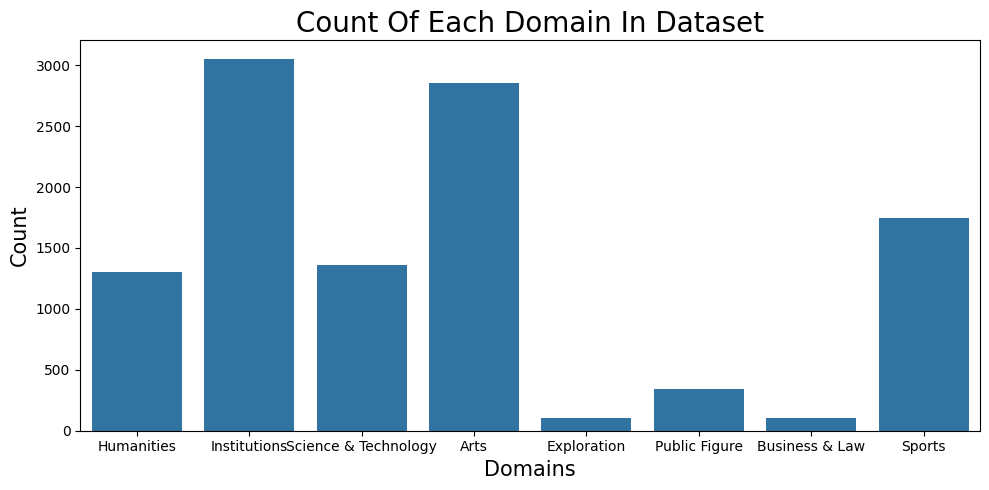

In [11]:
# bar plot to show above
plt.figure(figsize= (10,5))
sns.countplot(data = df_smaller, x = 'domain')
plt.title('Count Of Each Domain In Dataset',fontsize = 20)
plt.xlabel("Domains",fontsize =15)
plt.ylabel("Count",fontsize =15)
plt.tight_layout()

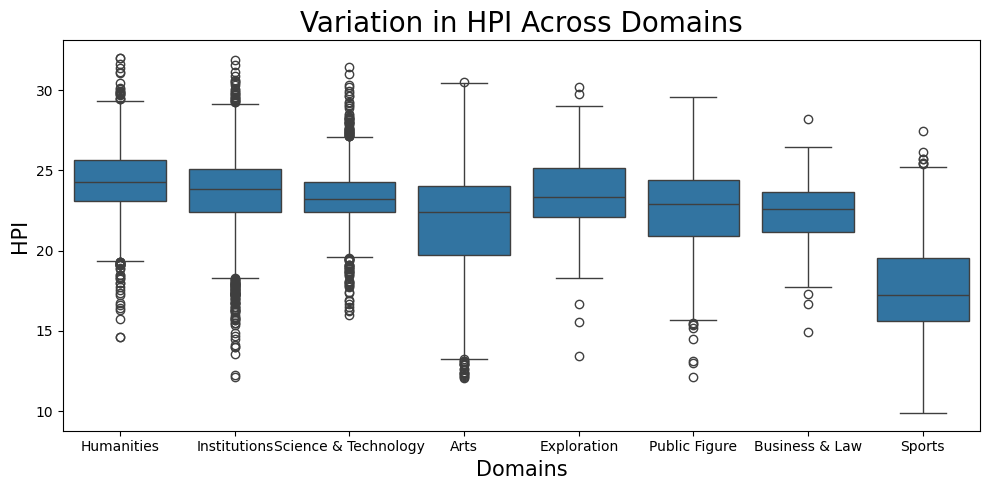

In [12]:
plt.figure(figsize= (10,5))
sns.boxplot(data = df_smaller,x = 'domain', y = 'HPI')
plt.title('Variation in HPI Across Domains',fontsize = 20)
plt.xlabel("Domains",fontsize =15)
plt.ylabel("HPI",fontsize =15)
plt.tight_layout()

POPULAR DOMAINS IN EACH CONTINENT,GENDER, AND BC and AD

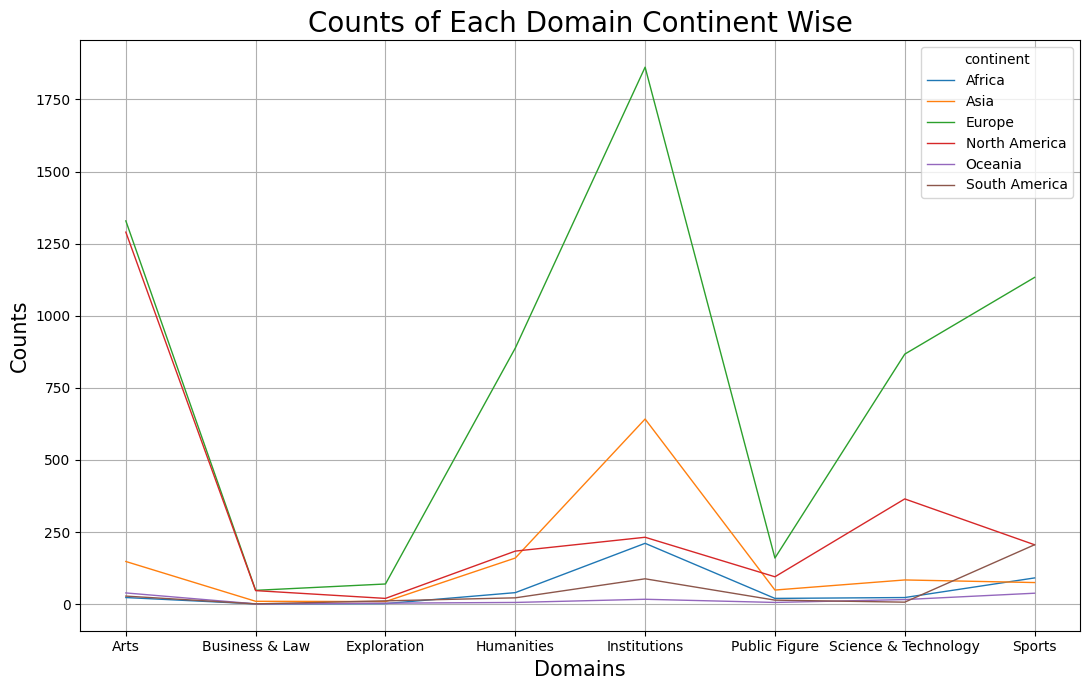

In [13]:
# Continent
d = df_smaller.groupby(['domain','continent']).count()[['name']]
plt.figure(figsize = (11,7))
p = sns.lineplot(data =  d,x = 'domain',y='name',hue = 'continent',linewidth = 1)
plt.title('Counts of Each Domain Continent Wise',fontsize = 20)
plt.xlabel("Domains",fontsize =15)
plt.ylabel("Counts",fontsize =15)
p.grid(True)
p.set_facecolor('white')
plt.tight_layout()

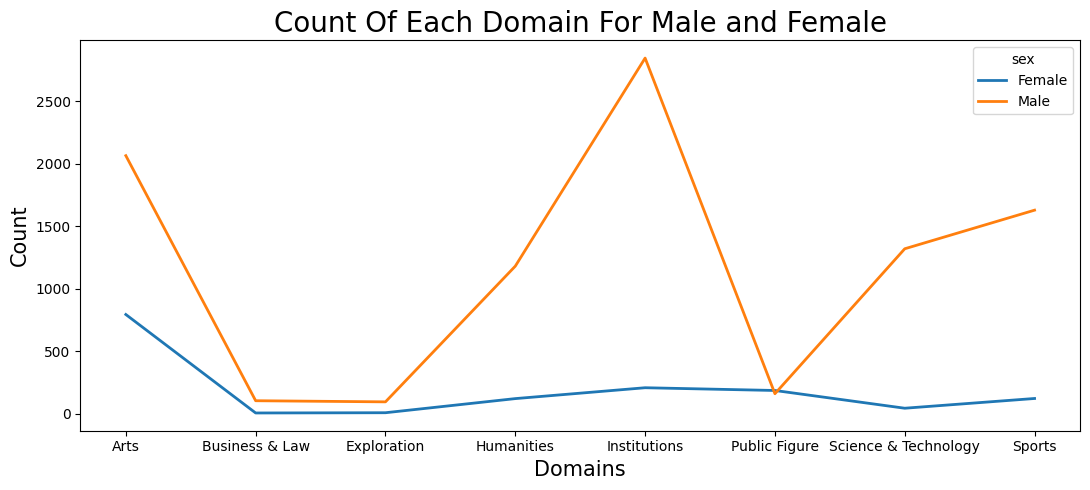

In [14]:
# Gender
d = df_smaller.groupby(['domain','sex']).count()[['name']]
plt.figure(figsize = (11,5))
sns.lineplot(data =  d,x = 'domain',y='name',hue = 'sex',linewidth = 2)
plt.title('Count Of Each Domain For Male and Female',fontsize = 20)
plt.xlabel("Domains",fontsize =15)
plt.ylabel("Count",fontsize =15)
plt.tight_layout()

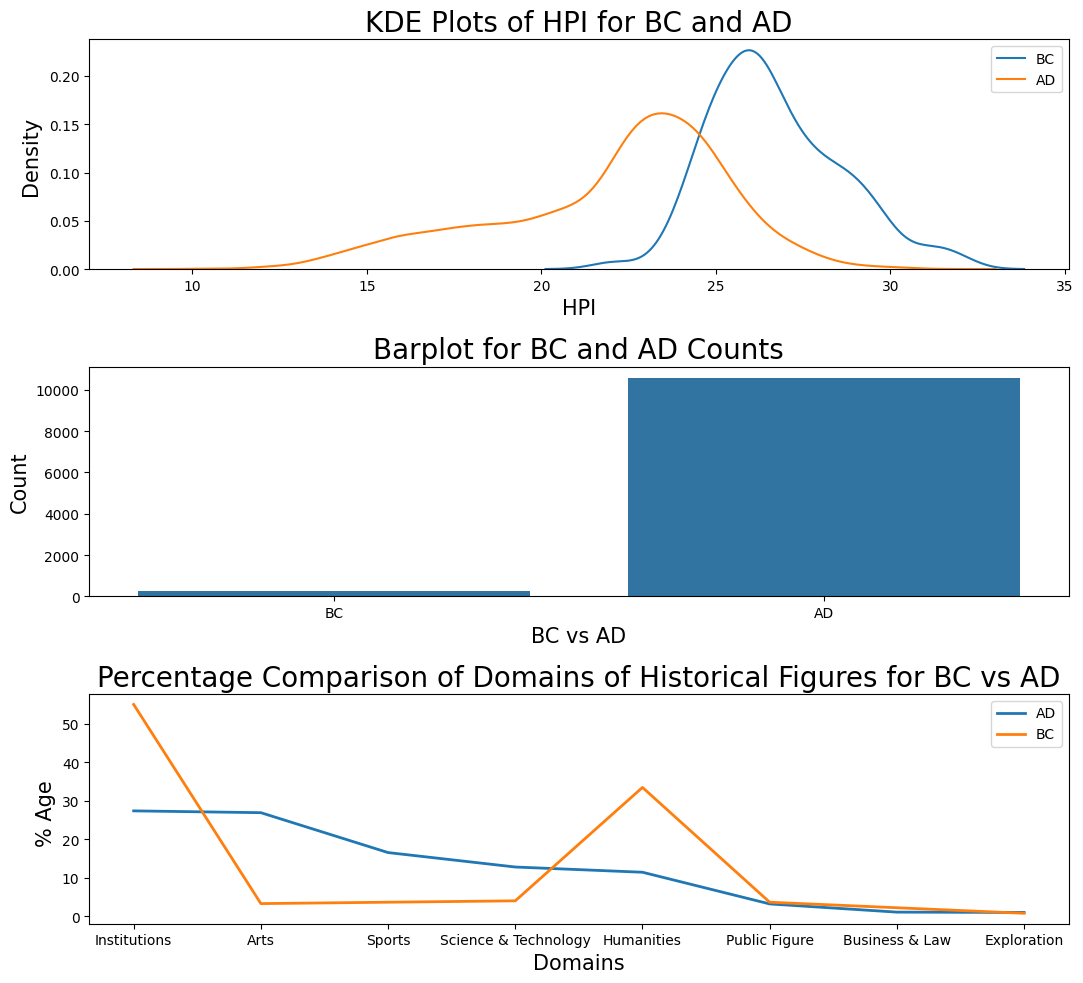

In [15]:
d_bc = df_smaller[df_smaller['birth_year'] < 0]
d_ad = df_smaller[df_smaller['birth_year'] > 0]
fig,a =  plt.subplots(3,1,figsize =(11,10))
y = [len(d_bc),len(d_ad)]
x = ['BC', 'AD']
sns.kdeplot(ax = a[0],data = d_bc, x = 'HPI', label = 'BC')
sns.kdeplot(ax = a[0],data = d_ad, x = 'HPI', label = 'AD')
a[0].legend()
sns.barplot(ax= a[1],x = x, y = y)
a[1].set_ylabel('Count')
a[1].set_xlabel('BC vs AD')
d_ad['period'] = 'AD'
d_bc['period'] = 'BC'
combined = pd.concat([d_ad,d_bc])
combined=combined.groupby('period')['domain'].value_counts(normalize = True).to_frame('Probability')
combined['Probability'] *= 100
c = combined.reset_index()
sns.lineplot(ax= a[2], data = c,x = 'domain', y='Probability',linewidth = 2,hue = 'period')
a[2].set_ylabel('% Age ',fontsize =15)
a[1].set_ylabel('Count',fontsize =15)
a[0].set_ylabel('Density ',fontsize =15)
a[2].set_xlabel('Domains',fontsize =15)
a[1].set_xlabel('BC vs AD',fontsize =15)
a[0].set_xlabel('HPI',fontsize =15)
a[0].set_title('KDE Plots of HPI for BC and AD',fontsize =20)
a[1].set_title('Barplot for BC and AD Counts',fontsize =20)
a[2].set_title('Percentage Comparison of Domains of Historical Figures for BC vs AD', fontsize = 20)
plt.legend()
sns.set(font_scale = 1)
fig.tight_layout()

We observe that Institutions, Arts, and Humanities seem to be the most popular since they show good represent in both top1000 and complete dataset. Sports is 3rd popular in terms of prevalence in complete data but is the lowest prevalent in top1000.

Industrial analysis

In [16]:
df_ind = df_smaller.copy().groupby('industry')
dff = df_ind.count()[['name']]
dff = dff.reset_index().sort_values(by = 'name',ascending = False)

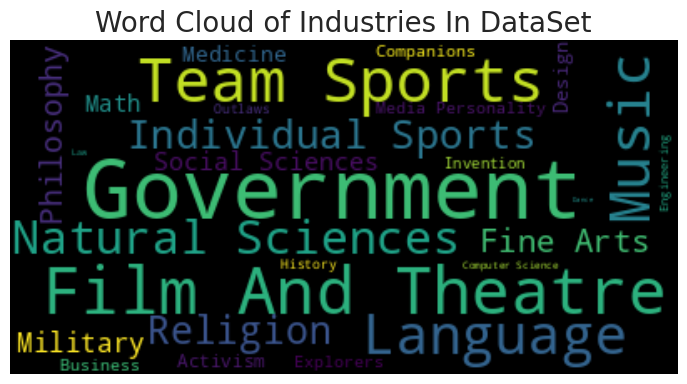

In [17]:
# full dataset
d = {}
for a, x in dff.values:
    d[a] = x
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize = (10, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud of Industries In DataSet',fontsize = 20)
plt.tight_layout()
plt.show()

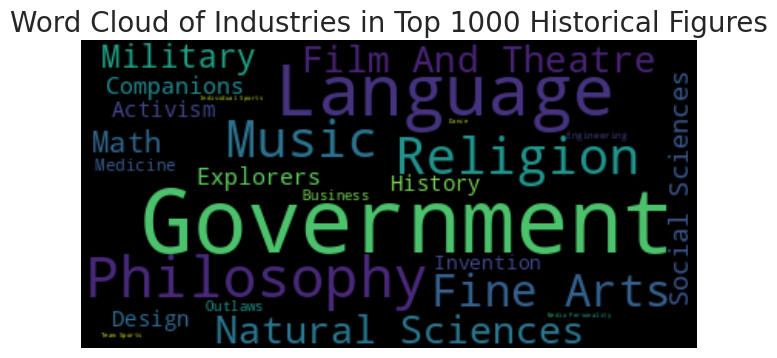

In [18]:
# top1000
df_ind1 = df_smaller.copy().iloc[:1000,:].groupby('industry')
dff1 = df_ind1.count()[['name']]
dff1 = dff1.reset_index().sort_values(by = 'name',ascending = False)
d = {}
for a, x in dff1.values:
    d[a] = x
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize = (10, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Industries in Top 1000 Historical Figures',fontsize = 20)
plt.axis("off")
plt.show()

In [19]:
info = df_smaller.groupby(['domain','industry'])[['name']].count()
modes = df_smaller.groupby('domain').agg(lambda x:x.value_counts().index[0])[['industry']]

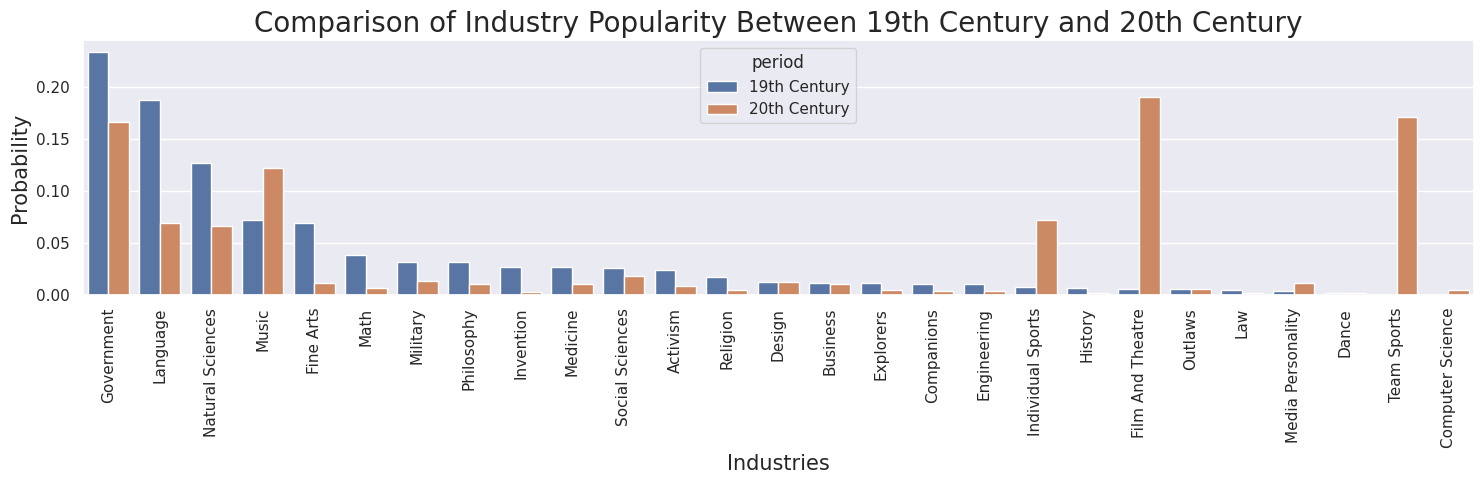

In [20]:
# change in popularity of domains from 19th century to current time
df19th = df_smaller.copy()[['birth_year','industry','domain']]
df19th = df19th[(df19th['birth_year'] > 1780) & (df19th['birth_year'] < 1880)]
df19th['period'] = '19th Century'
df20th = df_smaller.copy()[['birth_year','industry','domain']]
df20th = df20th[(df20th['birth_year'] >1880)]
df20th['period'] = '20th Century'
d = pd.concat([df19th,df20th])
d=d.groupby('period')['industry'].value_counts(normalize = True).to_frame('Probability').reset_index()
plt.figure(figsize = (15,5))
sns.barplot(data = d, x = 'industry', y = 'Probability', hue = 'period')
plt.title('Comparison of Industry Popularity Between 19th Century and 20th Century',fontsize = 20)
plt.xlabel("Industries",fontsize =15)
plt.ylabel("Probability",fontsize =15)
plt.xticks(rotation = 90)
plt.tight_layout()

HeatMaps

In [23]:
!pip install folium

import folium
import folium.plugins

SF_COORDINATES = (37.87, -122.28)
sf_map = folium.Map(zoom_start=5)
locs = df[['latitude', 'longitude']].astype('float').dropna().to_numpy()
heatmap = folium.plugins.HeatMap(locs.tolist(), radius = 10)
sf_map.add_child(heatmap)

## How have particular events influenced popularity?

1) Death of Jesus Christ

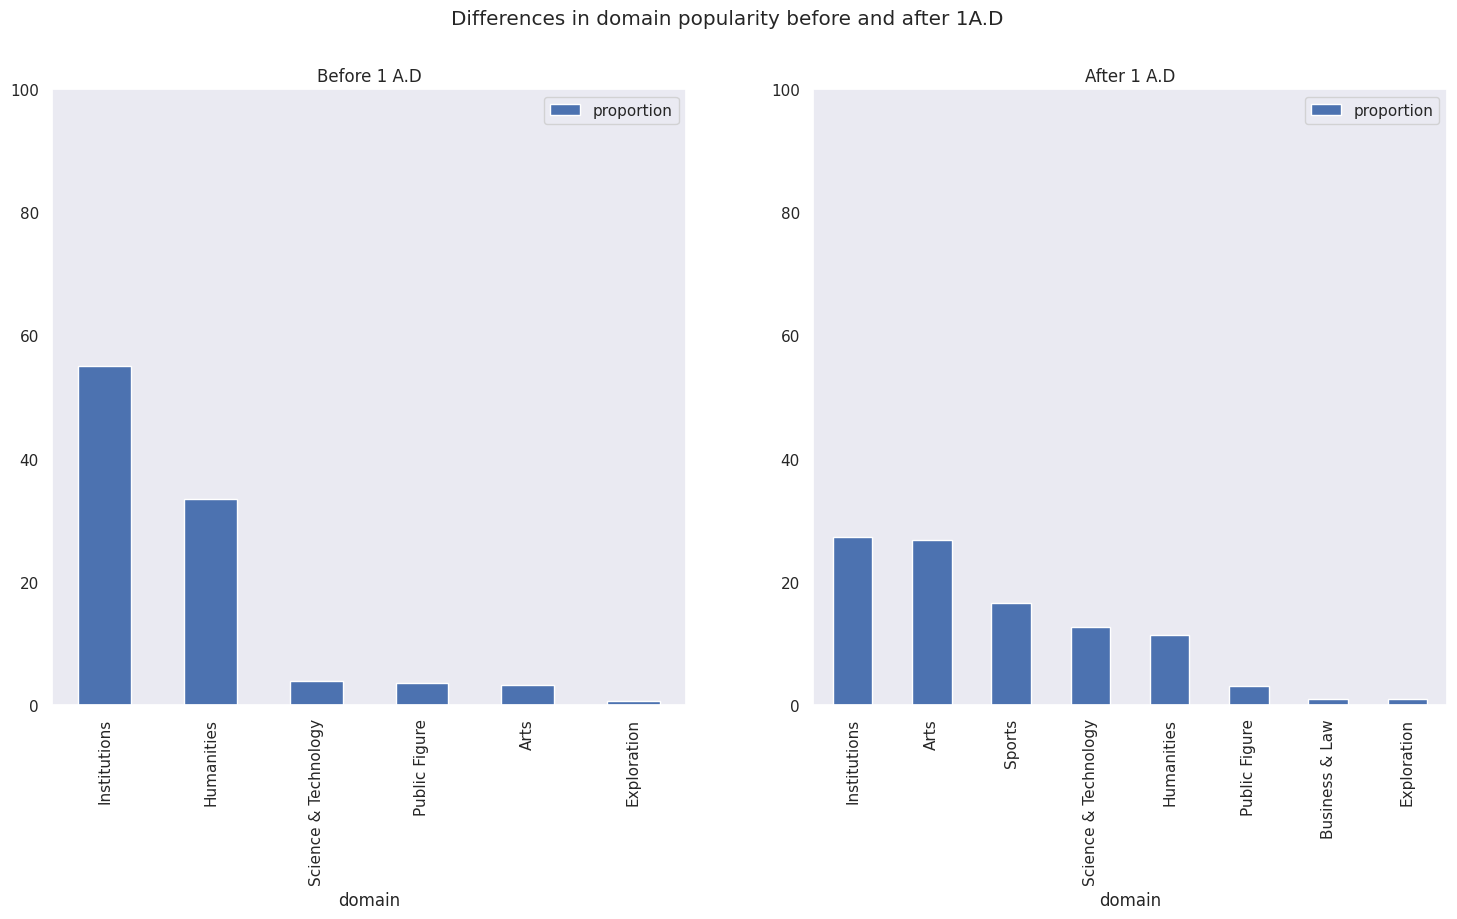

In [27]:
data=df.copy()

ad = data[data['birth_year'] >= 0]
bc = data[data['birth_year'] < 0]


x = bc['domain'].value_counts(normalize=True) * 100
y = ad['domain'].value_counts(normalize=True) * 100

xx = x.to_frame()
yy = y.to_frame()


fig, axes = plt.subplots(figsize=(18,8),nrows=1, ncols=2)
fig.suptitle('Differences in domain popularity before and after 1A.D')

xx.plot(ax=axes[0], kind='bar', grid=False)
yy.plot(ax=axes[1], kind='bar', grid=False)

axes[0].set_title('Before 1 A.D')
axes[1].set_title('After 1 A.D')
0
axes[1].set_ylim(0, 100)
axes[0].set_ylim(0, 100)
fig.savefig('sulisex.png')

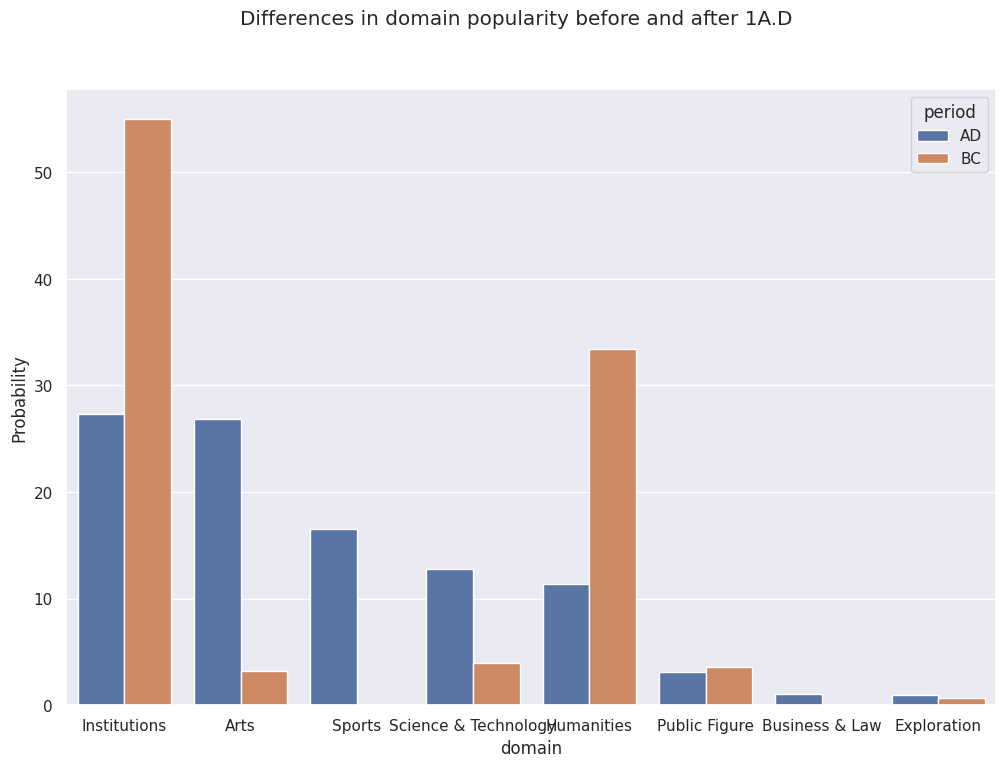

In [28]:
#Better representation of the data above, will use the below plot for all further analysis

ad = data[data['birth_year'] >= 0][['birth_year','domain']]
bc = data[data['birth_year'] < 0][['birth_year','domain']]
ad['period'] = 'AD'
bc['period'] = 'BC'
combined = pd.concat([ad,bc])
combined=combined.groupby('period')['domain'].value_counts(normalize = True).to_frame('Probability')
combined['Probability'] *= 100
c = combined.reset_index()
plt.figure(figsize = (12,8))
sns.barplot(data = c, x = 'domain', y = 'Probability', hue = 'period')
plt.suptitle('Differences in domain popularity before and after 1A.D')
plt.savefig('adbc.png')

2) The Renaissance

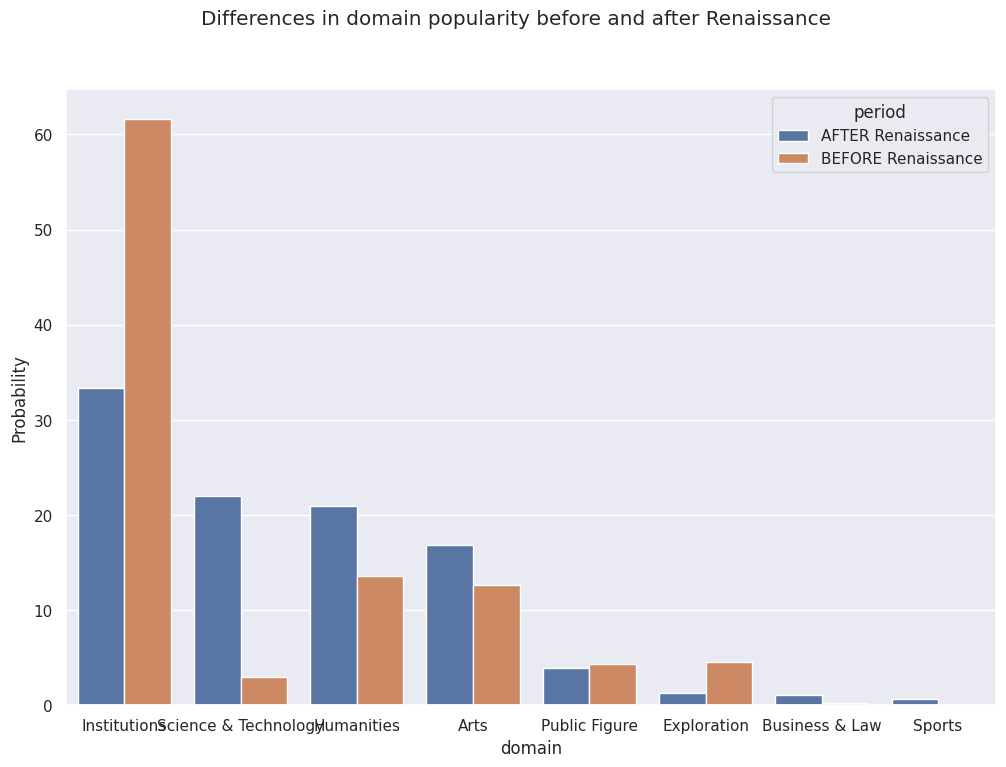

In [29]:
#I believe that this might have led to an increase in science and tech and also humanities
#Sources suggest that this was not a single event rather than a series of events, between 14th and 15th century. Taking 1500 A.D as an arbitrary year



before = data[(data['birth_year'] > 1100) & (data['birth_year'] < 1500)][['birth_year','domain']]
after = data[(data['birth_year'] > 1500) & (data['birth_year'] < 1900)][['birth_year','domain']]
before['period'] = 'BEFORE Renaissance'
after['period'] = 'AFTER Renaissance'
combined = pd.concat([before,after])
combined=combined.groupby('period')['domain'].value_counts(normalize = True).to_frame('Probability')
combined['Probability'] *= 100
c = combined.reset_index()
plt.figure(figsize = (12,8))
sns.barplot(data = c, x = 'domain', y = 'Probability', hue = 'period')

plt.suptitle('Differences in domain popularity before and after Renaissance')
plt.savefig('renaissane.png')


3) World War 2

<Axes: xlabel='domain', ylabel='Percentage of total'>

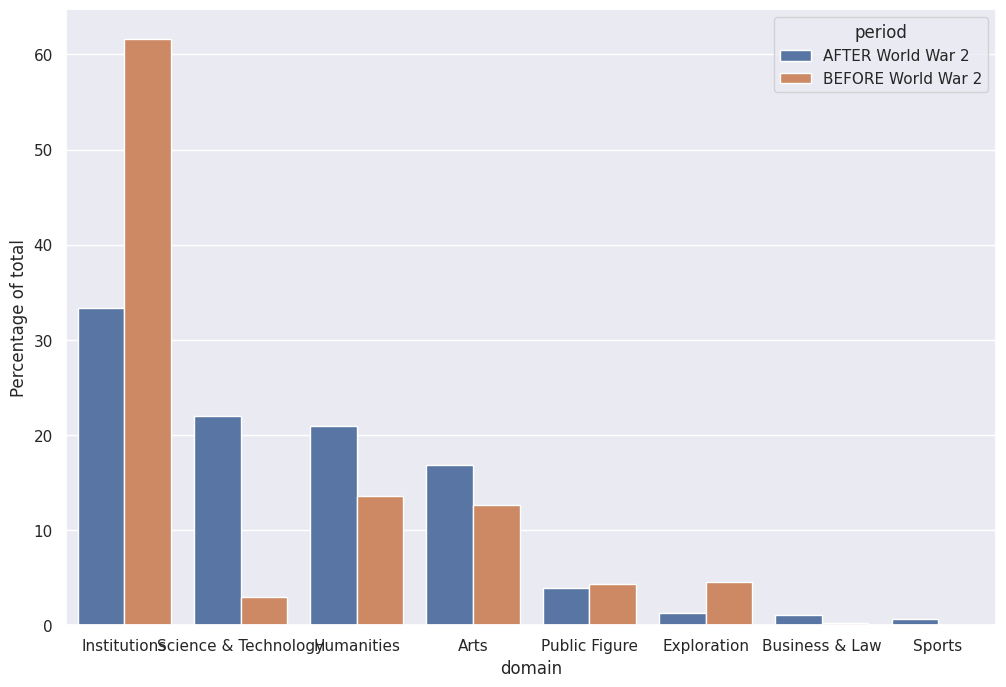

In [30]:


#The WW2 ended in 1945, however, we will take 1900 as the year of difference as our dataset contains birth years of all records.
#Assuming a personality takes around 40-45 years to make an impact, 1900 is a safe arbitrary differential to notice the differences before and after 1900.

beforeWW2 = data[(data['birth_year'] > 1100) & (data['birth_year'] < 1500)][['birth_year','domain']]
afterWW2 = data[(data['birth_year'] > 1500) & (data['birth_year'] < 1900)][['birth_year','domain']]
beforeWW2['period'] = 'BEFORE World War 2'
afterWW2['period'] = 'AFTER World War 2'
combined = pd.concat([beforeWW2,afterWW2])
combined=combined.groupby('period')['domain'].value_counts(normalize = True).to_frame('Percentage of total')
combined['Percentage of total'] *= 100
c = combined.reset_index()
plt.figure(figsize = (12,8))
sns.barplot(data = c, x = 'domain', y = 'Percentage of total', hue = 'period')


<Axes: xlabel='domain', ylabel='Percentage of total'>

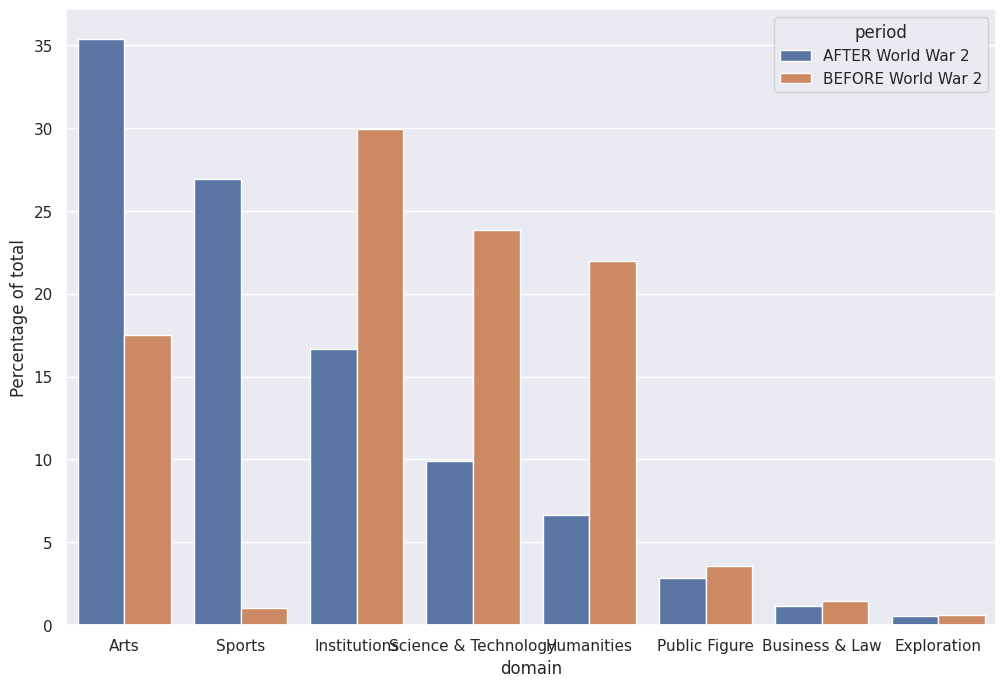

In [31]:
beforeWW2 = data[(data['birth_year'] > 1800) & (data['birth_year'] < 1900)][['birth_year','domain']]
afterWW2 = data[(data['birth_year'] > 1900) & (data['birth_year'] < 2000)][['birth_year','domain']]
beforeWW2['period'] = 'BEFORE World War 2'
afterWW2['period'] = 'AFTER World War 2'
combined = pd.concat([beforeWW2,afterWW2])
combined=combined.groupby('period')['domain'].value_counts(normalize = True).to_frame('Percentage of total')
combined['Percentage of total'] *= 100
c = combined.reset_index()
plt.figure(figsize = (12,8))
sns.barplot(data = c, x = 'domain', y = 'Percentage of total', hue = 'period')


#sports has increased a lot in the past few years
#Arts increased tremendously


4) 1760 - INDUSTRIAL REVOLUTION

<Axes: xlabel='domain', ylabel='Percentage of total'>

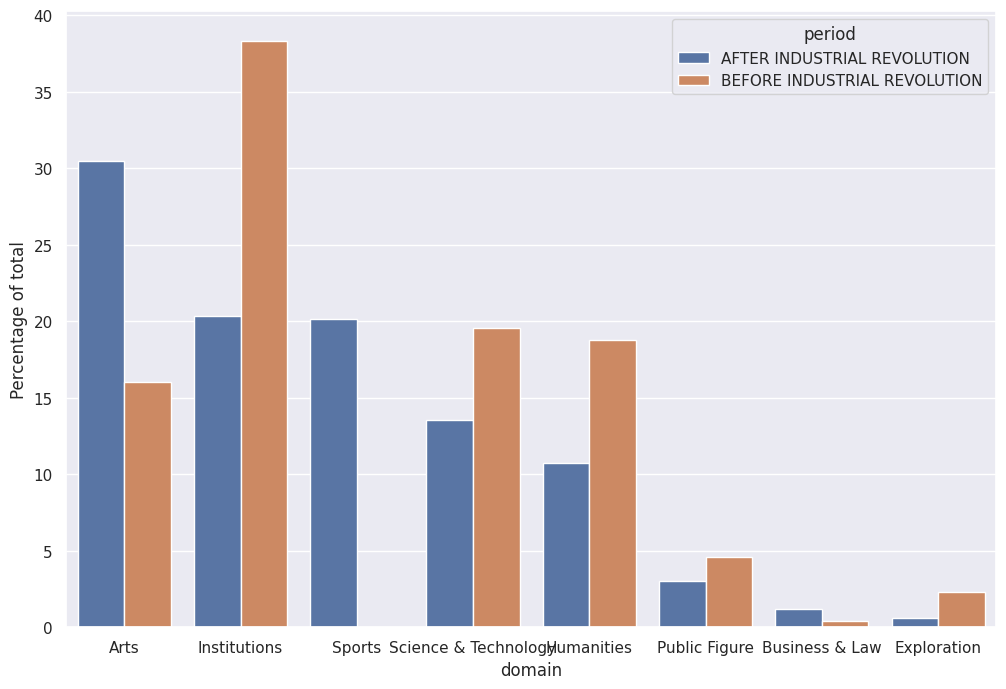

In [32]:


beforeIR = data[(data['birth_year'] > 1600) & (data['birth_year'] < 1760)][['birth_year','domain']]
afterIR = data[(data['birth_year'] > 1760) & (data['birth_year'] < 2000)][['birth_year','domain']]
beforeIR['period'] = 'BEFORE INDUSTRIAL REVOLUTION'
afterIR['period'] = 'AFTER INDUSTRIAL REVOLUTION'
combined = pd.concat([beforeIR,afterIR])
combined=combined.groupby('period')['domain'].value_counts(normalize = True).to_frame('Percentage of total')
combined['Percentage of total'] *= 100
c = combined.reset_index()
plt.figure(figsize = (12,8))
sns.barplot(data = c, x = 'domain', y = 'Percentage of total', hue = 'period')





5) INNOVATION IN TECH:

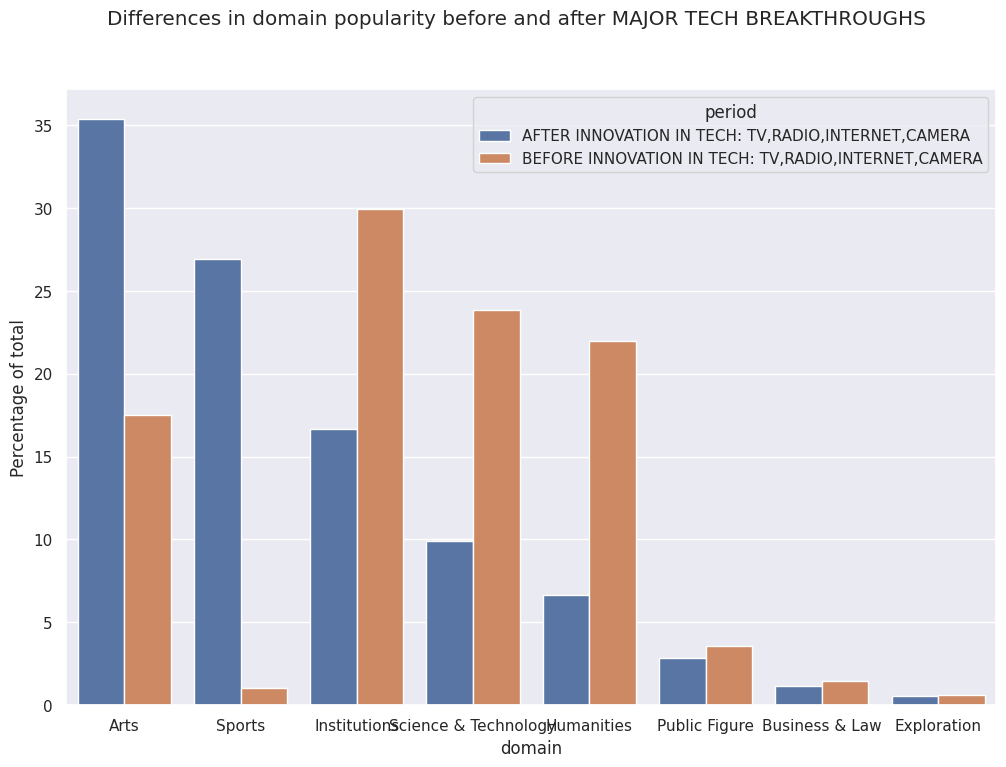

In [33]:
#RADIO,TV,INTERNET,CAMERA all of this happened in the 20th century. Taking 1900 as an arbitrary year
#we can look at the difference in various domains before and after 1900.

#MAJOR FINDING: THE SPORTS INDUSTRY AND THE ARTS INDUSTRY EXPERIENCED MAJOR GROWTH DUE TO ADVANCEMENT IN THESE TECHNOLOGIES
#SPORTS GAINED A LOT OF EXPOSURE IN THE LAST CENTURY DUE TO VARIOUS GAMES GETTING TELECASTED AND SHOWN TO A LARGER AUDIENCE
#THIS MADE SPORTS A GLOBAL PHENOMENA AND SPORTSMEN INFLUENTIAL.


beforeC = data[(data['birth_year'] > 1800) & (data['birth_year'] < 1900)][['birth_year','domain']]
afterC = data[(data['birth_year'] > 1900) & (data['birth_year'] < 2000)][['birth_year','domain']]
beforeC['period'] = 'BEFORE INNOVATION IN TECH: TV,RADIO,INTERNET,CAMERA'
afterC['period'] = 'AFTER INNOVATION IN TECH: TV,RADIO,INTERNET,CAMERA'
combined = pd.concat([beforeC,afterC])
combined=combined.groupby('period')['domain'].value_counts(normalize = True).to_frame('Percentage of total')
combined['Percentage of total'] *= 100
c = combined.reset_index()
c


plt.figure(figsize = (12,8))
sns.barplot(data = c, x = 'domain', y = 'Percentage of total', hue = 'period')
plt.suptitle('Differences in domain popularity before and after MAJOR TECH BREAKTHROUGHS')
plt.savefig('sports.png')


## How does wikipedia statistics affects a person' popularity?

In [34]:
#columns of interest: name, id, HPI, translations, views, average_views,
df.shape
df['name'].nunique()
df['name'].isnull().sum()
df['id'].nunique()
df.dtypes
df[df['name']=='other']
contains_non_string = df['name'][df['name'].apply(type) != str].any()
contains_non_string
df[df['name'].duplicated(keep=False)]
df.head()

,id,name,sex,birth_year,country,continent,latitude,longitude,industry,domain,translations,views,average_views,HPI
0,308,Aristotle,Male,-384,Greece,Europe,40.33333,23.50000,Philosophy,Humanities,152,56355172,370758,31.9938
1,22954,Plato,Male,-427,Greece,Europe,37.96667,23.71667,Philosophy,Humanities,142,46812003,329662,31.9888
2,1095706,Jesus Christ,Male,-4,Israel,Asia,32.50000,34.90000,Religion,Institutions,214,60299092,281771,31.8981
3,25664190,Socrates,Male,-469,Greece,Europe,37.96667,23.71667,Philosophy,Humanities,137,40307143,294213,31.6521
4,783,Alexander the Great,Male,-356,Greece,Europe,40.80000,22.51667,Military,Institutions,138,48358148,350421,31.5840


Reg plot of HPI against number of translations (num of translations seems to be the most likely factor from all of the wikipedia statistics that affect HPI)

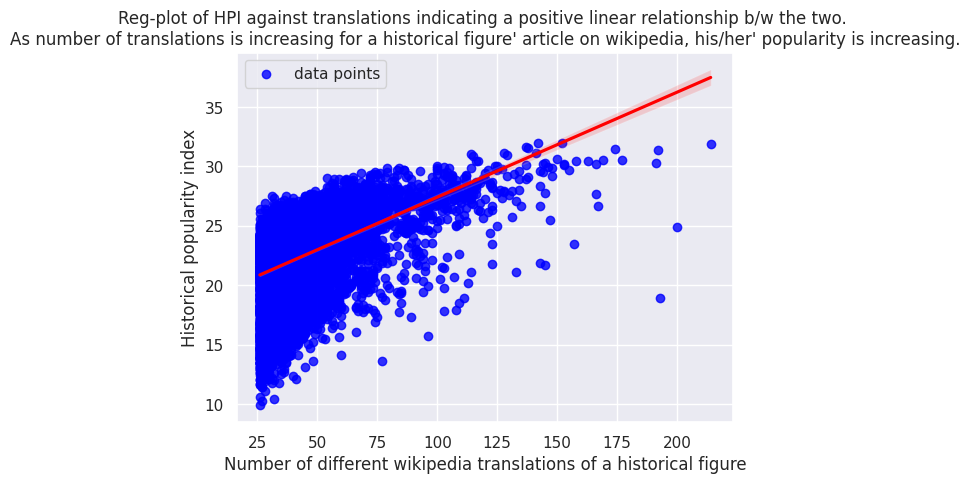

In [36]:
#to show the positive linear relation b/w HPI and the number of translations. Number of translat
sns.regplot(x="translations", y="HPI", data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, label='data points')
plt.title("Reg-plot of HPI against translations indicating a positive linear relationship b/w the two. \nAs number of translations is increasing for a historical figure' article on wikipedia, his/her' popularity is increasing.")
plt.legend()
plt.xlabel("Number of different wikipedia translations of a historical figure")
plt.ylabel("Historical popularity index")
plt.show()


Reg plot of HPI against other wikipedia statistics

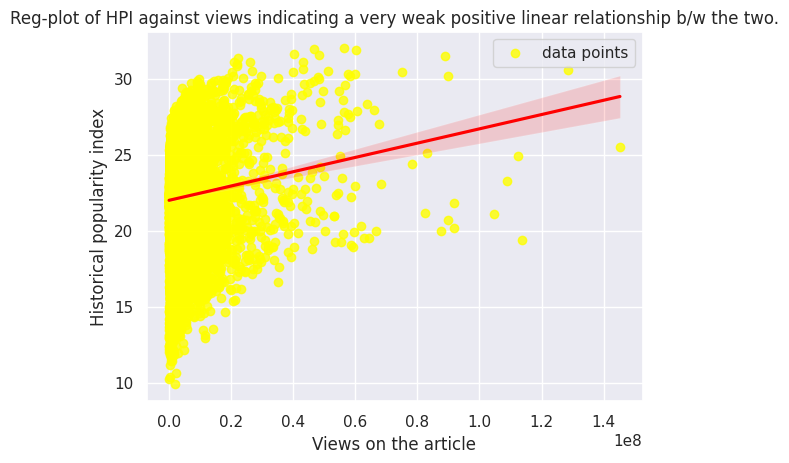

In [37]:
#against views
sns.regplot(x="views", y="HPI", data=df, scatter_kws={"color": "yellow"}, line_kws={"color": "red"}, label='data points')
plt.title("Reg-plot of HPI against views indicating a very weak positive linear relationship b/w the two.")
plt.legend()
plt.xlabel("Views on the article")
plt.ylabel("Historical popularity index")
plt.show()

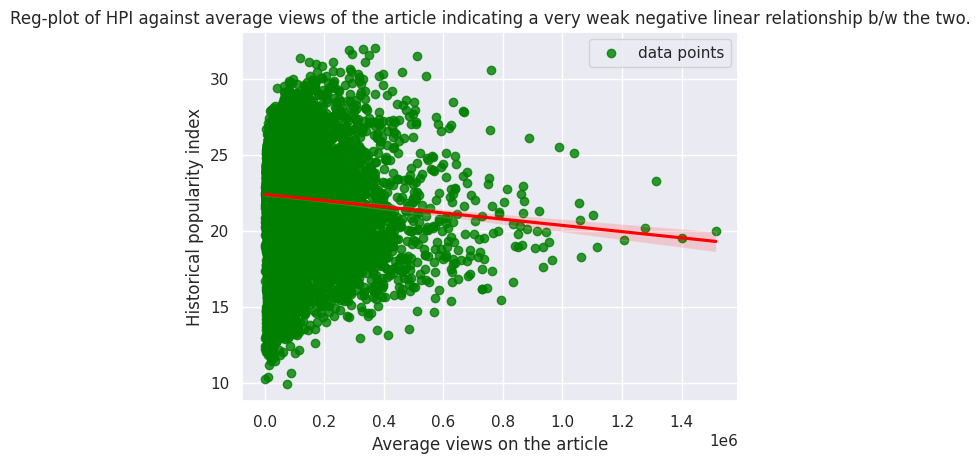

In [38]:
#against average views
sns.regplot(x="average_views", y="HPI", data=df, scatter_kws={"color": "green"}, line_kws={"color": "red"}, label='data points')
plt.title("Reg-plot of HPI against average views of the article indicating a very weak negative linear relationship b/w the two.")
plt.legend()
plt.xlabel("Average views on the article")
plt.ylabel("Historical popularity index")
plt.show()

## What is the relationship between popularity and gender?

 (a) Gender Proportion in the Dataset

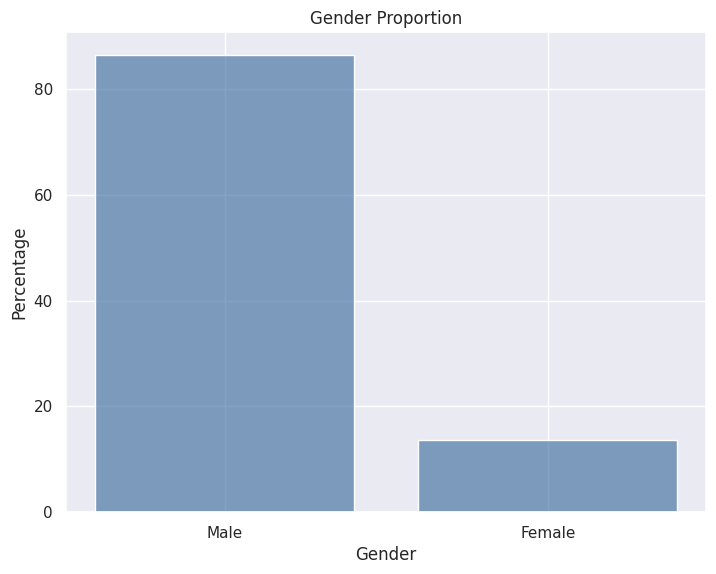

In [39]:
d = df.copy()

percentage = d['sex'].value_counts() / d['sex'].shape[0] * 100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bars = ['Male', 'Female']
ax.bar(bars, percentage, color=(0.2, 0.4, 0.6, 0.6))
ax.set(xlabel='Gender', ylabel='Percentage', title="Gender Proportion")

plt.show()

(b) KDE Plot

Skewness in the Male HPI graph:  -0.709229168706608
Skewness in the Female HPI graph:  -0.29674361131418936


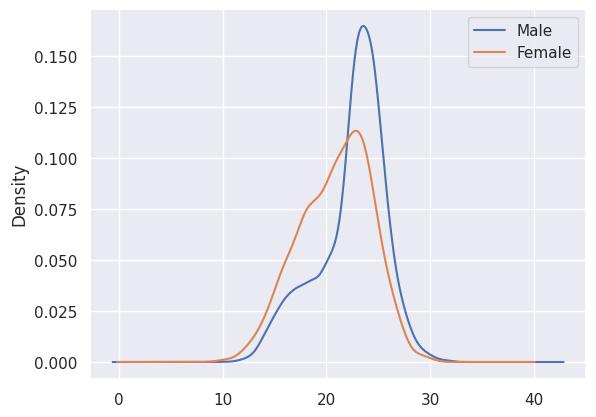

In [40]:
d = df.copy()
curves = ['Male', 'Female']
#ax1 = sns.kdeplot(data=d.loc[d['sex']=='Male'], x='hpi', label='Male',
#            fill=True, common_norm=False, palette="crest",
#            alpha=.5, linewidth=0,
#          )
male_hpi = d.loc[d['sex']=='Male', 'HPI']
ax_male = male_hpi.plot.kde(label='Male')
print("Skewness in the Male HPI graph: ", male_hpi.skew())

female_hpi = d.loc[d['sex']=='Female', 'HPI']
ax_female = female_hpi.plot.kde(label='Female')
print("Skewness in the Female HPI graph: ", female_hpi.skew())
plt.legend()

c) Popularity of Women in different Continents?

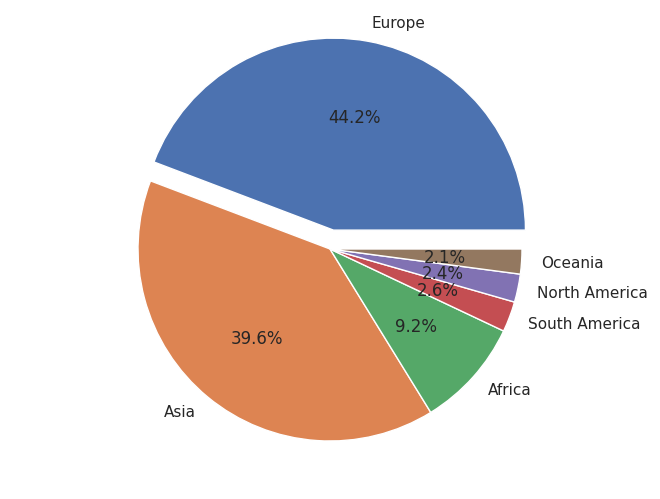

In [41]:
#Europe has the highest number of women in the dataset
d = df.copy()
regional_df = d.loc[d['sex']=='Female', 'continent']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
continents = d['continent'].unique()
counts = regional_df.value_counts()
ax.pie(counts, explode=(0.1, 0, 0, 0, 0, 0), labels=continents, autopct='%1.1f%%')
plt.show()


d) Fields of Study according to Gender

<Axes: xlabel='domain', ylabel='name'>

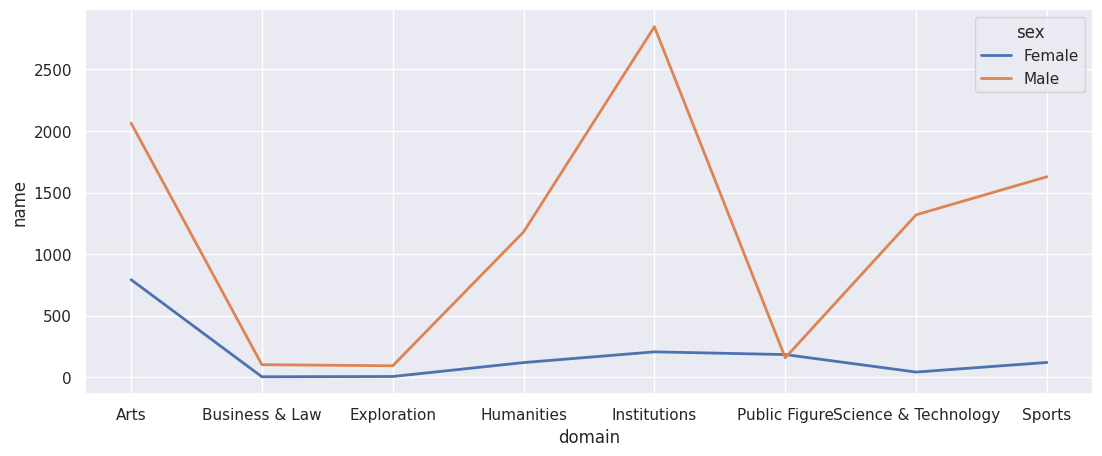

In [42]:
#Women scored the best in Arts, while men were best in the domain of Institutions.
d = df.copy()

d = d.groupby(['domain','sex']).count()[['name']]
plt.figure(figsize = (13,5))
sns.lineplot(data=d, x='domain', y='name', hue = 'sex', linewidth = 2)

(e) Top 5 country with most popular women

In [43]:
d = df.copy()

national_df = d.loc[d['sex']=='Female', 'country']
top_five = national_df.value_counts().head(5)

print(top_five)

country
United States     526
United Kingdom    157
France             91
Germany            59
Russia             49
Name: count, dtype: int64


## What role does ethnicity play in determining popularity?

Correlation Matrix

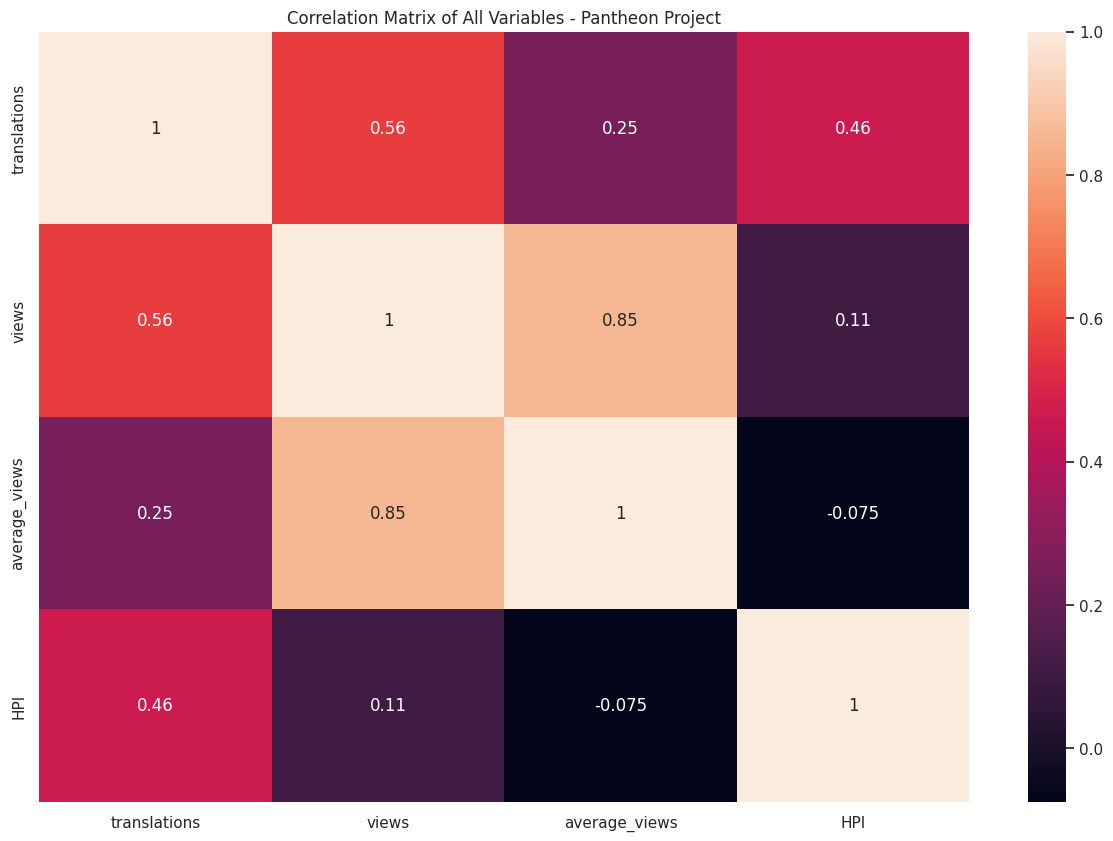

In [44]:
dataset=df.copy()
#What is the relationship between variables?
plt.figure(figsize=(15,10))
mask = ['translations', 'views', 'average_views', 'HPI']
corrMatrix = dataset[mask].corr()
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation Matrix of All Variables - Pantheon Project')
plt.show()

What are the top 10 countries with most number of historical figures?

country
United States     2169
United Kingdom    1147
France             867
Italy              809
Germany            748
Russia             374
Spain              296
Turkey             204
Poland             173
Netherlands        160
Name: count, dtype: int64 



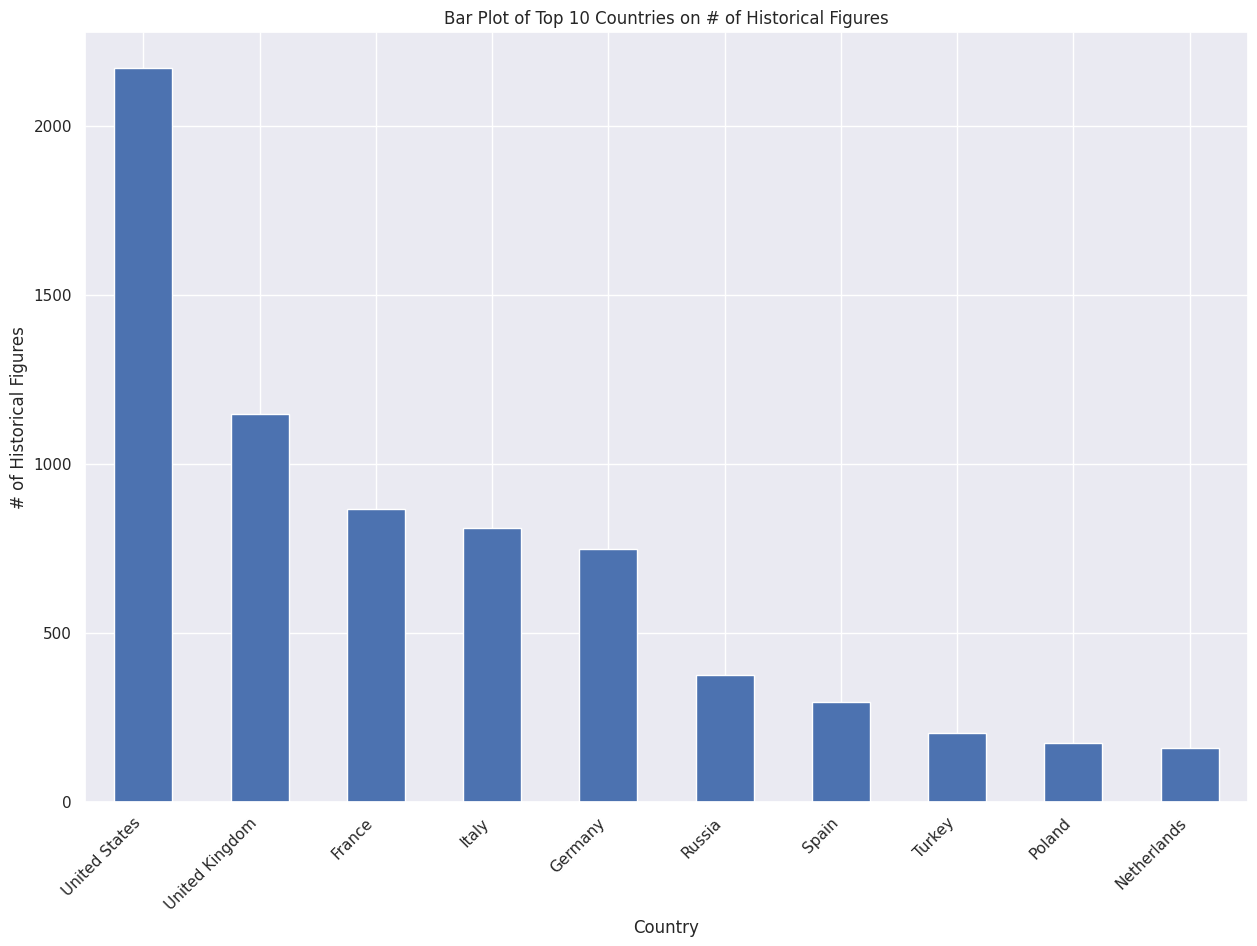

In [45]:
overall = dataset['country'].value_counts()
print(overall.head(10), "\n")

plt.figure(figsize=(15,10))
bar = overall.head(10).plot(kind = 'bar')

bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
bar.set_xlabel("Country")
bar.set_ylabel("# of Historical Figures")
plt.title('Bar Plot of Top 10 Countries on # of Historical Figures')
plt.show()

What is the distribution of Historical Figures by Continent?

continent
Europe           6357
North America    2439
Asia             1177
Africa            411
South America     366
Oceania           123
Name: count, dtype: int64 



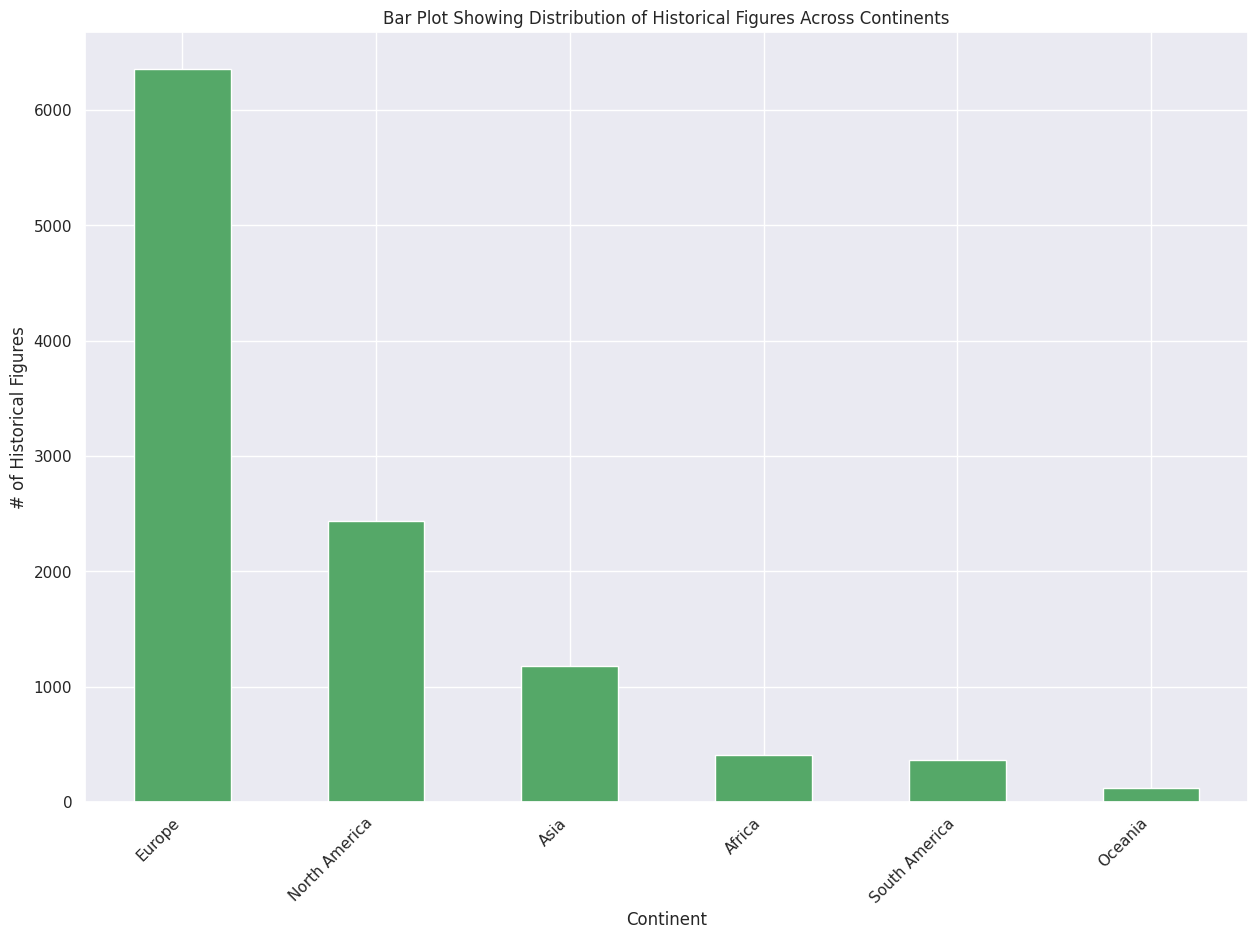

In [47]:
overall_continent = dataset['continent'].value_counts()
print(overall_continent, "\n")

plt.figure(figsize=(15,10))
bar = overall_continent.plot(kind = 'bar', color = 'g')

bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
bar.set_xlabel("Continent")
bar.set_ylabel("# of Historical Figures")
plt.title('Bar Plot Showing Distribution of Historical Figures Across Continents')
plt.show()

What continent do the 10 most popular Hisotrical Figures belong to?

In [48]:
dataset[['name','continent', 'HPI']].sort_values(by = "HPI", ascending = False).head(10)

,name,continent,HPI
0,Aristotle,Europe,31.9938
1,Plato,Europe,31.9888
2,Jesus Christ,Asia,31.8981
3,Socrates,Europe,31.6521
4,Alexander the Great,Europe,31.5840
5,Leonardo da Vinci,Europe,31.4644
6,Confucius,Asia,31.3705
7,Julius Caesar,Europe,31.1161
8,Homer,Europe,31.1087
9,Pythagoras,Europe,31.0691


What did the distribution of Historical figures from the 19th century across continents look like?

In [49]:
d_19th = dataset[(dataset['birth_year'] > 1780) & (dataset['birth_year'] <1880)][['country','continent']]
d_20th = dataset[dataset['birth_year'] >1880][['country','continent']]
d_19th['period'] = '19th'
d_20th['period'] = '20th'
d_19th
d_19th['continent'].value_counts()

,count
continent,
Europe,1082
North America,185
Asia,76
South America,16
Africa,14
Oceania,3


## Conclusion

The Pantheon dataset was an interesting dataset which provided answers to several key questions that we initially set out to answer. We were able to extract some useful information and trends among popular personalities and their domains, ethnicity, gender etc. However, there are endless possibilities when it comes to exploring and drawing inferences from data. A lot of our analysis was based on certain assumptions hence there are limitations of the analyses presented above.

Despite these limitations, performing all the steps of the data-science lifecycle on this particular data set was quite insightful and a great learning experience.